In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/Colab Notebooks/eff-btrfly

/content/drive/MyDrive/Colab Notebooks/eff-btrfly


In [3]:
!pip install --upgrade efficientnet-pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16427 sha256=16f44e6093d7deca65fd64981095fb4be220c76035149564ff3e68cf1954d33e
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet-pytorch


In [4]:
#from btreff import BtrflyNet

from varianbtreff import BtrflyNet #coba varian EfficientNet

In [5]:
import torch

device = 'cuda'

kupu = BtrflyNet().to(device)
kupu.load_state_dict( torch.load('./kupu-model/model-eff0406a.pt') )

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/adv-efficientnet-b7-4652b6dd.pth" to /root/.cache/torch/hub/checkpoints/adv-efficientnet-b7-4652b6dd.pth
100%|██████████| 255M/255M [00:09<00:00, 27.2MB/s]


Loaded pretrained weights for efficientnet-b7
Loaded pretrained weights for efficientnet-b7


<All keys matched successfully>

In [6]:
from PIL import Image
from torchvision import transforms

tfms = transforms.Compose([transforms.ToTensor()])

In [7]:
import matplotlib.pyplot as plt
import numpy as np

imsize = (512, 128, 1)

def masking(msk):
    tmp = msk.round()
    return [(tmp == i).astype('float').tolist() for i in range(13)]

In [8]:
import os

X, y = [], []

for name in os.listdir(f'./data/img'):
    if name[-5] == '1':
        X.append([
            tfms(Image.open(f'./data/img/{name[:-5]}1.png')).tolist(),
            tfms(Image.open(f'./data/img/{name[:-5]}2.png')).tolist()
        ])
        y.append([
            masking(plt.imread(f'./data/msk/{name[:-5]}1.png')[...,0] * 12),
            masking(plt.imread(f'./data/msk/{name[:-5]}2.png')[...,0] * 12)
        ])

vl = [ 6, 29,  0, 22, 34, 30,  4, 31]
tr = [i for i in range(37) if i not in vl]

X_train, X_valid = torch.Tensor( [X[i] for i in tr] ), torch.Tensor( [X[j] for j in vl] )
y_train, y_valid = torch.Tensor( [y[i] for i in tr] ), torch.Tensor( [y[j] for j in vl] )

n_data_train, n_data_valid = len(X_train), len(X_valid)

In [9]:
def masking_torch(msk):
    return torch.Tensor([ (msk == i).cpu().numpy().astype('float') for i in range(13) ])

In [10]:
import timeit

inp_size = (1,  3, 512, 128)
out_size = (1, 13, 512, 128)
dsc_size = (1, 1, 13, 512, 128)

start = timeit.default_timer()

with torch.no_grad():

    for i in range(n_data_train):
        
        x, y = X_train[i], y_train[i]
        
        out_ant, out_pos = kupu(
            x[0].reshape(inp_size).to(device),
            x[1].reshape(inp_size).to(device)
        )

        tmp = torch.cat([
            masking_torch(out_ant.argmax(axis=1)[0]).reshape(dsc_size),
            masking_torch(out_pos.argmax(axis=1)[0]).reshape(dsc_size)
        ], axis=1)

        if i == 0: y_predt = tmp + 0
        else: y_predt = torch.cat([y_predt, tmp], axis=0)

    for i in range(n_data_valid):
        
        x, y = X_valid[i], y_valid[i]
        
        #data uji
        out_ant, out_pos = kupu(
            x[0].reshape(inp_size).to(device),
            x[1].reshape(inp_size).to(device)
        )

        tmp = torch.cat([
            masking_torch(out_ant.argmax(axis=1)[0]).reshape(dsc_size),
            masking_torch(out_pos.argmax(axis=1)[0]).reshape(dsc_size)
        ], axis=1)

        if i == 0: y_predv = tmp + 0
        else: y_predv = torch.cat([y_predv, tmp], axis=0)

stop = timeit.default_timer()

print('Time: ', stop - start)

<ipython-input-9-89ed43dc3f24>:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  return torch.Tensor([ (msk == i).cpu().numpy().astype('float') for i in range(13) ])


Time:  16.161283829000013


In [11]:
cp = {
         0 : [1.0       , 1.0       , 1.0       ],
         1 : [0.6901961 , 0.9019608 , 0.05098039],
         2 : [0.        , 0.5921569 , 0.85882354],
         3 : [0.49411765, 0.9019608 , 0.8862745 ],
         4 : [0.6509804 , 0.21568628, 0.654902  ],
         5 : [0.9019608 , 0.6156863 , 0.7058824 ],
         6 : [0.654902  , 0.43137255, 0.3019608 ],
         7 : [0.47843137, 0.        , 0.09411765],
         8 : [0.22352941, 0.25490198, 0.72156864],
         9 : [0.9019608 , 0.85490197, 0.        ],
        10 : [0.9019608 , 0.44705883, 0.13725491],
        11 : [0.05098039, 0.7372549 , 0.24313726],
        12 : [0.9019608 , 0.7137255 , 0.08627451]
}

def map_clr(mask):
    res = []
    for row in mask:
        new_row = [cp[x] for x in row]
        res.append(new_row)
    return np.array(res)

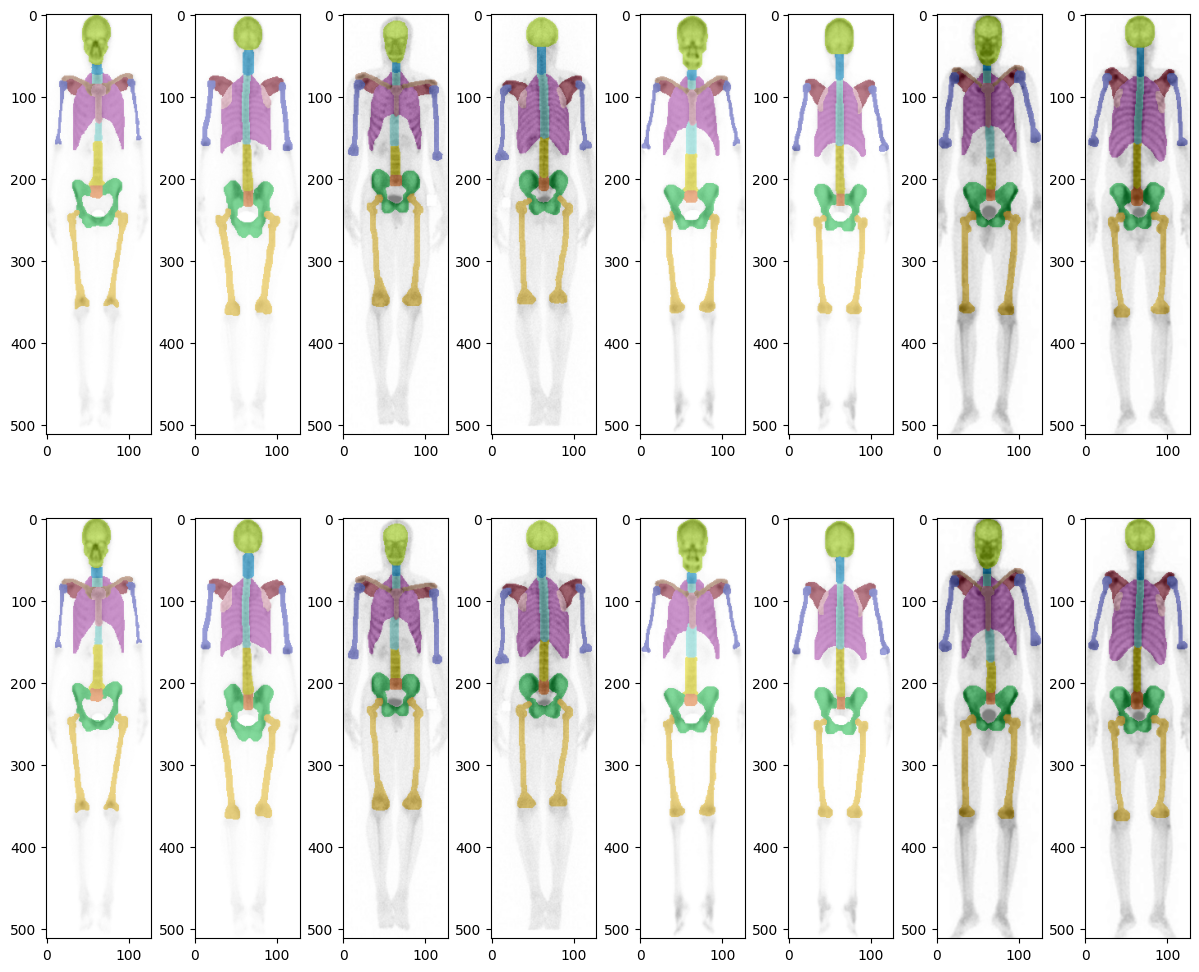

In [12]:
#visualisasi data train
n = 4

np.random.seed(76)

tr_idx = np.random.choice(range(n_data_train), n, False)
vl_idx = np.random.choice(range(n_data_valid), n, False)

plt.figure(figsize=(15, n*3))
for i in range(n):
    
    plt.subplot(2, n*2, (2*i)+1)
    plt.imshow(X_train[tr_idx[i]][0].permute(1, 2, 0))
    plt.imshow(map_clr(y_predt[tr_idx[i]][0].argmax(axis=0).numpy()), alpha=0.5)

    plt.subplot(2, n*2, (2*i)+2)
    plt.imshow(X_train[tr_idx[i]][1].permute(1, 2, 0))
    plt.imshow(map_clr(y_predt[tr_idx[i]][1].argmax(axis=0).numpy()), alpha=0.5)

    plt.subplot(2, n*2, (n*2)+(2*i)+1)
    plt.imshow(X_train[tr_idx[i]][0].permute(1, 2, 0))
    plt.imshow(map_clr(y_train[tr_idx[i]][0].argmax(axis=0).numpy()), alpha=0.5)

    plt.subplot(2, n*2, (n*2)+(2*i)+2)
    plt.imshow(X_train[tr_idx[i]][1].permute(1, 2, 0))
    plt.imshow(map_clr(y_train[tr_idx[i]][1].argmax(axis=0).numpy()), alpha=0.5)

#plt.savefig('./ujieff_0406a-1.png')

In [13]:
#visualisasi data uji
n=8
#print(vl_idx)
plt.figure(figsize=(60, n*3))
#plt.figure(figsize=(15, n*3))
for i in range(n):
    plt.subplot(2, n*2, (2*i)+1)
    plt.imshow(X_valid[i][0].permute(1, 2, 0))
    plt.imshow(map_clr(y_predv[i][0].argmax(axis=0).numpy()), alpha=0.5)
    
    plt.subplot(2, n*2, (2*i)+2)
    plt.imshow(X_valid[i][1].permute(1, 2, 0))
    plt.imshow(map_clr(y_predv[i][1].argmax(axis=0).numpy()), alpha=0.5)
    
    plt.subplot(2, n*2, (n*2)+(2*i)+1)
    plt.imshow(X_valid[i][0].permute(1, 2, 0))
    plt.imshow(map_clr(y_valid[i][0].argmax(axis=0).numpy()), alpha=0.5)
    
    plt.subplot(2, n*2, (n*2)+(2*i)+2)
    plt.imshow(X_valid[i][1].permute(1, 2, 0))
    plt.imshow(map_clr(y_valid[i][1].argmax(axis=0).numpy()), alpha=0.5)

plt.savefig('./ujieff-0406a-paper.png')

Output hidden; open in https://colab.research.google.com to view.

In [14]:
def dice_coef(y_true, y_pred):
    y_true_f = y_true[:,:,1:,:,:].flatten()
    y_pred_f = y_pred[:,:,1:,:,:].flatten()
    union = y_true_f.flatten().sum().item() + y_pred_f.flatten().sum().item()
    if union == 0: return 1
    intersection = (y_true_f * y_pred_f).sum().item()
    return 2 * intersection / union

dice_coef(y_train, y_predt)

0.9941491806977921

In [15]:
dice_coef(y_valid, y_predv)

0.8945764970962521

In [16]:
def dice_coef_all(y_true, y_pred):
    dice_scores = []
    for i in range(1,13):
        y_true_f = y_true[:,:,i,:,:].flatten()
        y_pred_f = y_pred[:,:,i,:,:].flatten()
        union = y_true_f.flatten().sum().item() + y_pred_f.flatten().sum().item()
        if union == 0:
            dice_scores.append(1)
        else:
            intersection = (y_true_f * y_pred_f).sum().item()
            dice_scores.append(2 * intersection / union)
    return dice_scores

In [17]:
import pandas as pd

segments = [
    'Skull (Green)',
    'Cervical Vertebrae (Blue)',
    'Thoracic Vertebrae (Light Blue)',
    'Ribs (Purple)',
    'Sternum (Pink)',
    'Clavicle (Light Brown)',
    'Scapula (Dark Brown)',
    'Humerus (Dark Blue)',
    'Lumbar Vertebrae (Yellow)',
    'Sacrum (Orange)',
    'Pelvis (Dark Green)',
    'Femur (Gold)'
]

pd.DataFrame({
    'Segment'    : segments,
    'Dice Score' : dice_coef_all(y_valid, y_predv)
})

#sternum tidak ada di posterior. Saat segmentasi nilainya akan diset 1 oleh program; harus di-exclude saat penghitungan dice score rata-rata

,Segment,Dice Score
0,Skull (Green),0.955650
1,Cervical Vertebrae (Blue),0.804440
2,Thoracic Vertebrae (Light Blue),0.864456
3,Ribs (Purple),0.921411
4,Sternum (Pink),0.851403
5,Clavicle (Light Brown),0.792134
6,Scapula (Dark Brown),0.857813
7,Humerus (Dark Blue),0.861691
8,Lumbar Vertebrae (Yellow),0.871111
9,Sacrum (Orange),0.822379


## **ANTERIOR**

In [18]:
def dice_coef_section(y_true, y_pred, sec):
    sec = {'ant' : 0, 'pos' : 1}[sec]
    dice_scores = []
    for i in range(1,13):
        y_true_f = y_true[:,sec,i,:,:].flatten()
        y_pred_f = y_pred[:,sec,i,:,:].flatten()
        union = y_true_f.flatten().sum().item() + y_pred_f.flatten().sum().item()
        if union == 0:
            dice_scores.append(1)
        else:
            intersection = (y_true_f * y_pred_f).sum().item()
            dice_scores.append(2 * intersection / union)
    return dice_scores

# anterior
pd.DataFrame({
    'Segment'    : segments,
    'Dice Score' : dice_coef_section(y_valid, y_predv, 'ant')
})

,Segment,Dice Score
0,Skull (Green),0.948874
1,Cervical Vertebrae (Blue),0.533658
2,Thoracic Vertebrae (Light Blue),0.806669
3,Ribs (Purple),0.921874
4,Sternum (Pink),0.865422
5,Clavicle (Light Brown),0.792134
6,Scapula (Dark Brown),0.848746
7,Humerus (Dark Blue),0.857247
8,Lumbar Vertebrae (Yellow),0.846203
9,Sacrum (Orange),0.801667


## **POSTERIOR**

In [19]:
# posterior
pd.DataFrame({
    'Segment'    : segments,
    'Dice Score' : dice_coef_section(y_valid, y_predv, 'pos')
})

,Segment,Dice Score
0,Skull (Green),0.965196
1,Cervical Vertebrae (Blue),0.863912
2,Thoracic Vertebrae (Light Blue),0.903142
3,Ribs (Purple),0.921024
4,Sternum (Pink),0.838427
5,Clavicle (Light Brown),1.000000
6,Scapula (Dark Brown),0.862989
7,Humerus (Dark Blue),0.866125
8,Lumbar Vertebrae (Yellow),0.893995
9,Sacrum (Orange),0.834830
